## 練習課題1
[岩崎君からのレビュー]

- 可視化する時の流れ  
　1. データの補正（Nanが無いかとか型を統一するとか）    
　2. 「df.describe()」で統計量を出し、「df.corr()」で相関係数を出す（seabornのpairplotでも良いけど、、、）    
　3. どのように可視化するかを考える、全体図は出すと良い    
- 関数を書くときは「docstring」を使って引数等の説明をすると良い
- コメントアウトとdocstringは他の人がコードを理解したり後で自分が見直したりするときに役立つので、積極的に使う
- 散布図を描く時、「matplotlibのscatterplot」でも良いけど、「seabornのjointplot」の方が汎用性があるし色々オプションを付けられるのでjointplotがおすすめ
- データ数が多くなるとヴァイオリンプロットよりswarmplotの方が便利
- データの重複をなくす時、「set()」も良いけど「.unique()」もある。uniqueはリストにできるからおすすめ
- 外れ値をグラフから除きたい場合は値の範囲を指定すれば良い！

In [1]:
import requests
from bs4 import BeautifulSoup
import time
import os
import datetime
import re
import csv
import pandas as pd
import openpyxl
import urllib.request

## スクレイピング

In [2]:
url_list = ["https://suumo.jp/jj/bukken/ichiran/JJ010FJ001/?ar=030&bs=021&ta=14"  \
            "&jspIdFlg=patternShikugun&sc=14101&sc=14102&sc=14103&sc=14104&sc=14105&sc=14106"  \
            "&sc=14107&sc=14108&sc=14109&sc=14110&sc=14111&sc=14112&sc=14113&sc=14114"  \
            "&sc=14115&sc=14116&sc=14117&sc=14118&kb=1&kt=9999999&tb=0&tt=9999999&hb=0"  \
            "&ht=9999999&ekTjCd=&ekTjNm=&tj=0&cnb=0&cn=9999999&srch_navi=1&pn={}",

            "https://suumo.jp/jj/bukken/ichiran/JJ010FJ001/?ar=030&bs=011&ta=14" \
            "&jspIdFlg=patternShikugun&sc=14101&sc=14102&sc=14103&sc=14104&sc=14105&sc=14106" \
            "&sc=14107&sc=14108&sc=14109&sc=14110&sc=14111&sc=14112&sc=14113&sc=14114" \
            "&sc=14115&sc=14116&sc=14117&sc=14118&kb=1&kt=9999999&mb=0&mt=9999999" \
            "&ekTjCd=&ekTjNm=&tj=0&cnb=0&cn=9999999&srch_navi=1&pn={}"]

In [3]:
# 収集するデータのカラム
cols = ["カテゴリ", "販売価格", "所在地", "区", "沿線", "最寄駅", "徒歩（分）", "バス（分）",
        "土地面積", "建物面積", "バルコニー", "間取り", "築年数"]

In [4]:
def identify_floor_plan(floor_plan):
    """
    間取りの種類が多すぎるのでまとめる
    
    Parameters
    ----------
    floor_plan: str, 間取りの種類
    
    """
    
    if floor_plan.find("ワンルーム") > -1:
        floor_plan = "1K"
    if floor_plan.find("+") > -1:
        floor_plan = floor_plan[:floor_plan.find("+")]
    if floor_plan.find("LK") > -1:
        floor_plan = floor_plan[0:1] + "LDK"
    if floor_plan.find("LL") > -1 or \
       floor_plan.find("DD") > -1 or \
       floor_plan.find("KK") > -1:
        floor_plan = floor_plan = floor_plan[0:1] + "LDK"

    return floor_plan

In [5]:
def convert_price(price):
    """
    販売価格の表示をそろえる
    
    Parameters
    ----------
    price : int, 円単位
    
    """
    
    #「〇万円※権利金含む」の処理
    if price.find("※") > -1:
        price = price[:price.find("※")]
    
    #「○○万円・○○万円」の処理
    if price.find("・") > -1:
        price = price[:price.find("・")]
    
    #「○○万円～○○万円」の処理
    if price.find("～") > -1:
        price = price[price.find("～") + 1:]
        #「億」が含まれる場合
        if price.find("億") > -1:
            #「1億円」ジャストのような場合の処理
            if price.find("万") == -1:
                price = int(price[:price.find("億")]) * 100000000
            else:
                oku = int(price[:price.find("億")]) * 100000000
                price = oku + int(price[price.find("億") + 1:-2]) * 10000
        #「億」が含まれない場合
        else:
            price = int(price[:price.find("万円")]) * 10000
            
    else:#数値に変換
        #「億」が含まれる場合
        if price.find("億") > -1:
            #「1億円」ジャストのような場合の処理
            if price.find("万") == -1:
                price = int(price[:price.find("億")]) * 100000000
            else:
                oku = int(price[:price.find("億")]) * 100000000
                price = oku + int(price[price.find("億") + 1:-2]) * 10000
        #「億」が含まれない場合
        else:
            if price.find("万円") > -1:
                price = int(price[:-2]) * 10000
            else:
                man = int(price[:price.find("万")]) * 10000
                price = man + int(price[price.find("万") + 1:-1])
            
    return price

In [6]:
def remove_brackets(data):
    """
    カッコとかを除く
    
    Parameters
    ----------
    data : str, 面積とか販売価格とかの補足情報を除く
    """
    
    # ○○～○○の処理
    if data.find("～") > -1:
        data = data[data.find("～") + 1:]

    # m2以降を除去
    if data.find("m2") > -1:
        data = data[:data.find("m")]
    if data.find("㎡") > -1:
        data = data[:data.find("㎡")]

    # （）を除去
    if data.find("（") > -1:
        data = data[:data.find("（")]

    return data

In [7]:
def get_line_station(line_station):
    """
    沿線の情報を統一する
    
    Parameters
    ----------
    line_station : str, 最寄り駅からの時間
    """

    # ＪＲをJRに変換
    if line_station.find("ＪＲ") > -1:
        line_station = line_station.replace("ＪＲ", "JR")

    # バスと徒歩の時間を取得
    if line_station.find("バス") > -1:
        bus_time = line_station[line_station.find("バス") + 2 : line_station.find("分")]

        # バスの場合は徒歩時間＝(バス時間×10) + バス停までの徒歩時間とする
        walk_time = line_station[line_station.find("停歩") + 2 : line_station.rfind("分")]

    else:
        bus_time = 0
        walk_time = line_station[line_station.find("徒歩") + 2 : line_station.rfind("分")]

    # 沿線と駅を取得
    line = line_station[ : line_station.find("「") ]

    if line.find("湘南新宿ライン高海") > -1 or line.find("湘南新宿ライン宇須") > -1:
        line = "湘南新宿ライン"

    station = line_station[line_station.find("「") + 1 : line_station.find("」")]

    return line, station, bus_time, walk_time

In [8]:
def get_page_count(hit_count):
    """
    ヒットした物件数の表示方法を統一する
    
    Parameters
    ----------
    hit_count : str, 検索でヒットしたペ物件数
    """

    # データ整形
    hit_count = hit_count.strip()
    hit_count = hit_count.replace(",", "")
    hit_count = hit_count.replace("件", "")

    # ページ数計算
    page_count = divmod(int(hit_count), 30)
    if page_count[1] == 0:
        page_count = page_count[0]
    else:
        page_count = page_count[0] + 1

    return page_count

In [9]:
def main():

    df = pd.DataFrame(index=[], columns=cols)

    for i, url_base in enumerate(url_list):
        # 対象urlのデータを取得
        url = url_base.format(1)
        html = urllib.request.urlopen(url).read()
        soup = BeautifulSoup(html)
        hit_count = soup.find("div", class_="pagination_set-hit").text

        # 各urlのページ数計算
        page_count = get_page_count(hit_count)

        data = {}
        for page in range(1, page_count + 1):

            # ページごとにリクエスト
            if page != 1:
                url = url_base.format(page)
                html = urllib.request.urlopen(url).read()
                soup = BeautifulSoup(html)

            for s in soup.findAll('div', 'dottable-line'):

                if i == 0:
                    data["カテゴリ"] = "中古一戸建て"

                else:
                    data["カテゴリ"] = "中古マンション"

                if len(s.findAll('dt')) == 1:
                    if s.find('dt').text == "販売価格":

                        # ○○万円を数字に変換
                        price = convert_price(s.find("span").text)
                        data["販売価格"] = price

                if len(s.findAll('dt')) == 2:

                    if s.findAll('dt')[0].text == "所在地":
                        area = s.findAll("dd")[0].text
                        data["所在地"] = area
                        data["区"] = area[area.find("市") + 1:area.find("区") + 1]

                    if s.findAll('dt')[1].text == "沿線・駅":

                        # データ加工
                        line, station, bus_time, \
                            walk_time = get_line_station(s.findAll("dd")[1].text)

                        data["沿線"] = line
                        data["最寄駅"] = station
                        data["徒歩（分）"] = walk_time
                        data["バス（分）"] = bus_time

                if s.find('table', class_ = 'dottable-fix') != None:
                    if s.findAll('dt')[0].text == "土地面積":

                        land_area = remove_brackets(s.findAll("dd")[0].text)
                        data["土地面積"] = land_area

                    if s.findAll('dt')[1].text == "間取り":

                        floor_plan = remove_brackets(s.findAll("dd")[1].text)

                        # 間取りをまとめる
                        floor_plan = identify_floor_plan(floor_plan)
                        data["間取り"] = floor_plan

                    if s.findAll('dt')[0].text == "建物面積":

                        house_area = remove_brackets(s.findAll("dd")[0].text)
                        data["建物面積"] = house_area

                    if s.findAll('dt')[0].text == "専有面積":

                        house_area = remove_brackets(s.findAll("dd")[0].text)
                        data["建物面積"] = house_area

                        # 中古マンションは建物面積＝土地面積とする
                        data["土地面積"] = house_area

                    if s.findAll('dt')[0].text == "バルコニー":

                        if s.findAll("dd")[0].text.find("-") > -1:
                            data["バルコニー"] = 0
                        else:
                            balcony_area = remove_brackets(s.findAll("dd")[0].text)
                            data["バルコニー"] = balcony_area

                    else: # 一戸建ての場合は0
                        data["バルコニー"] = 0

                    if s.findAll('dt')[1].text == "築年月":

                        # 築年数を算出
                        built_year = 2021 - int(s.findAll("dd")[1].text[:4])
                        data["築年数"] = built_year

                # データフレームに1物件ずつデータを格納
                if len(data) == 13:
                    df = df.append(data, ignore_index=True)
                    data = {}

    # CSV 出力
    df.to_csv("sample.csv", index=False, encoding = "utf-8")

if __name__ == '__main__':
    main()

## 可視化

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font = "Yu Gothic")
%matplotlib inline

In [3]:
df = pd.read_csv("sample.csv")
df = df.astype({'建物面積': 'float64'})

In [4]:
df.head()

,カテゴリ,販売価格,所在地,区,沿線,最寄駅,徒歩（分）,バス（分）,土地面積,建物面積,バルコニー,間取り,築年数
0,中古一戸建て,16800000,神奈川県横浜市保土ケ谷区岩崎町,保土ケ谷区,JR横須賀線,保土ヶ谷,23,0,118.27,80.73,0.0,4DK,27
1,中古一戸建て,17500000,神奈川県横浜市緑区上山２,緑区,JR横浜線,中山,21,0,173.89,119.54,0.0,3LDK,41
2,中古一戸建て,18800000,神奈川県横浜市旭区白根８,旭区,相鉄本線,横浜,5,26,100.17,99.33,0.0,2LDK,28
3,中古一戸建て,19800000,神奈川県横浜市旭区市沢町,旭区,JR横須賀線,東戸塚,3,11,65.71,98.95,0.0,4LDK,13
4,中古一戸建て,19800000,神奈川県横浜市旭区市沢町,旭区,相鉄本線,二俣川,3,25,65.71,98.95,0.0,4LDK,13


In [5]:
#欠損値が無いか確認
df.isnull().sum()

カテゴリ     0
販売価格     0
所在地      0
区        0
沿線       0
最寄駅      0
徒歩（分）    0
バス（分）    0
土地面積     0
建物面積     0
バルコニー    0
間取り      0
築年数      0
dtype: int64

In [6]:
#統計値
df.describe()

,販売価格,土地面積,建物面積,バルコニー,築年数
count,8.656000e+03,8656.000000,8656.000000,8656.000000,8656.000000
mean,3.577574e+07,87.622395,76.789696,6.774122,28.154921
std,2.634937e+07,73.848029,31.240057,6.569814,13.448755
min,3.300000e+06,11.180000,11.180000,0.000000,-1.000000
25%,2.480000e+07,59.407500,59.850000,0.000000,19.000000
50%,3.180000e+07,70.720000,71.275000,6.390000,28.000000
75%,3.990000e+07,91.220000,86.555000,10.400000,38.000000
max,1.245000e+09,3305.000000,759.130000,57.490000,94.000000


In [7]:
df[df["築年数"] == -1]

,カテゴリ,販売価格,所在地,区,沿線,最寄駅,徒歩（分）,バス（分）,土地面積,建物面積,バルコニー,間取り,築年数
8169,中古マンション,51800000,神奈川県横浜市神奈川区反町４,神奈川区,東急東横線,反町,4,0,51.04,51.04,0.0,1LDK,-1


築年数が-1なのは、来年の４月に建つ予定だから

In [8]:
#相関係数
df.corr()

,販売価格,土地面積,建物面積,バルコニー,築年数
販売価格,1.000000,0.573295,0.562469,0.101837,-0.360546
土地面積,0.573295,1.000000,0.753879,-0.216575,-0.083683
建物面積,0.562469,0.753879,1.000000,-0.154379,-0.217410
バルコニー,0.101837,-0.216575,-0.154379,1.000000,-0.039607
築年数,-0.360546,-0.083683,-0.217410,-0.039607,1.000000


販売価格、土地面積、建物面積、バルコニー、築年数の全体のプロット

### pairplot

<function matplotlib.pyplot.show(close=None, block=None)>

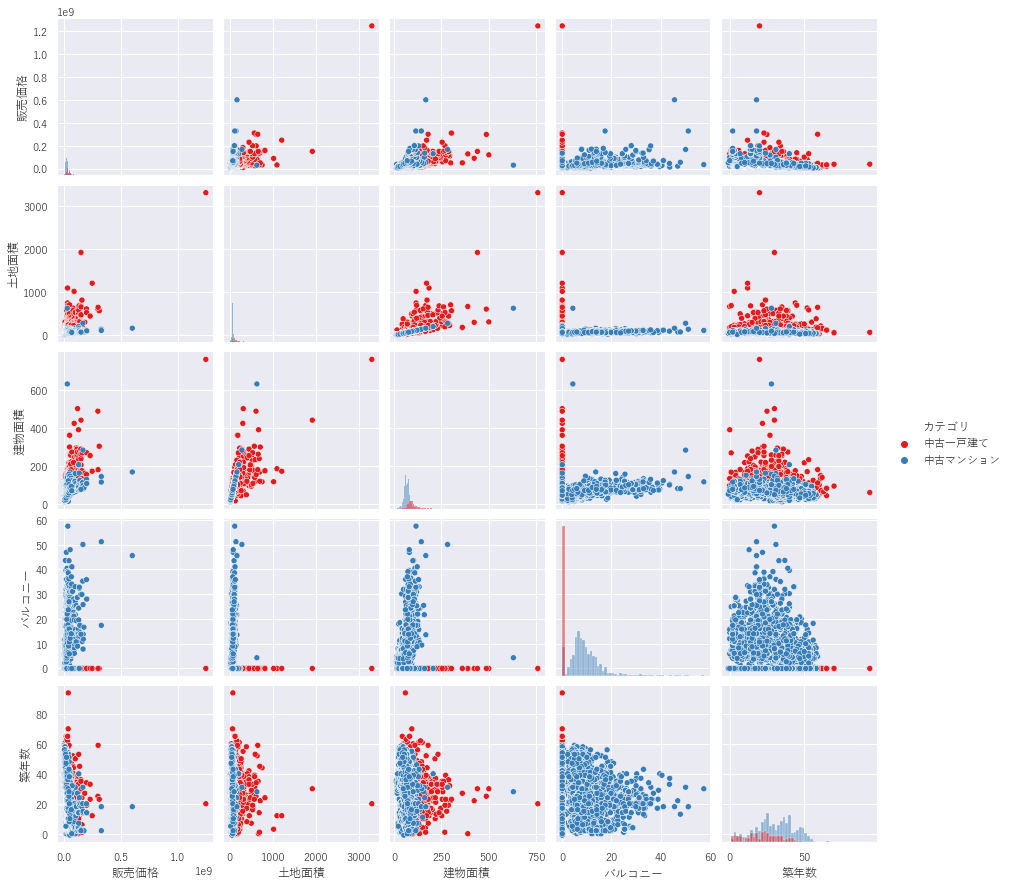

In [18]:
sns.pairplot(df, hue = "カテゴリ", diag_kind="hist", palette="Set1")
plt.show

pairplotのオプションについて→https://watlab-blog.com/2019/11/10/seaborn-pairplot/

**統計値と相関係数、pairplotから予想できること**  
相関係数からは、土地面積・建物面積と販売価格には正の相関があり、築年数と販売価格には非常に弱い負の相関がある、といえる  
pairplotからは築年数と販売価格の相関はあまり分からない

これは全体の結果なので、地区ごとに見ていくとどうだろう

In [19]:
ku = list(df["区"].unique())
df["区"].value_counts()

港北区      872
鶴見区      747
磯子区      669
南区       631
青葉区      613
戸塚区      581
神奈川区     564
中区       563
西区       495
保土ケ谷区    493
港南区      467
旭区       441
緑区       388
金沢区      362
都筑区      289
泉区       214
栄区       170
瀬谷区       97
Name: 区, dtype: int64

In [20]:
#"販売価格"と"区"のデータを抽出（でも使わなかった）
filtered = df.iloc[:,[1,3]]
filtered.head()

,販売価格,区
0,16800000,保土ケ谷区
1,17500000,緑区
2,18800000,旭区
3,19800000,旭区
4,19800000,旭区


### jointplot
販売価格と土地面積・建物面積・築年数について区ごとに見ていく

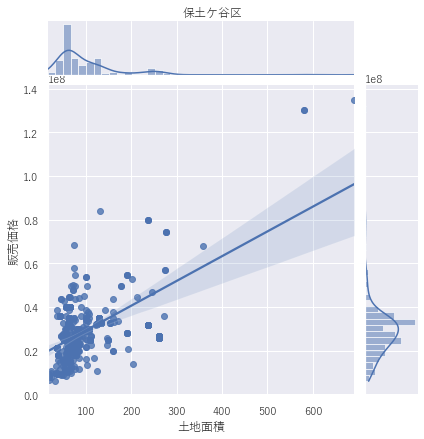

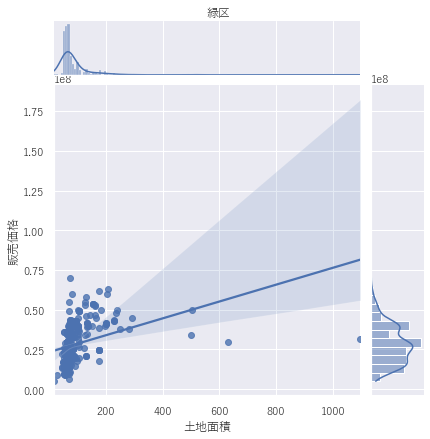

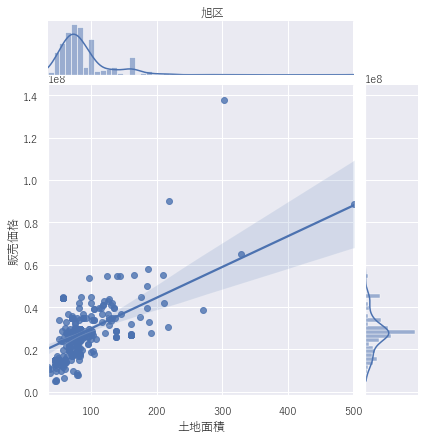

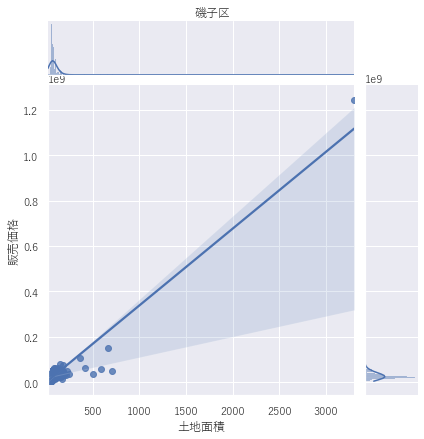

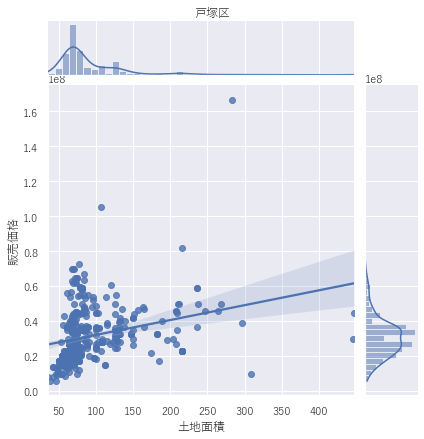

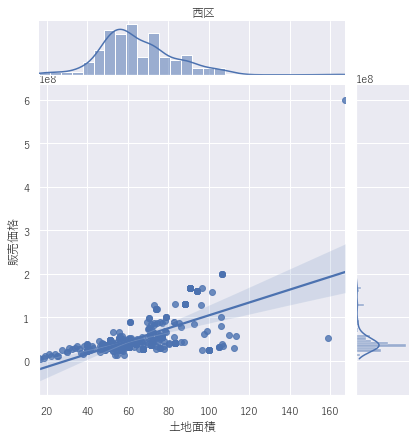

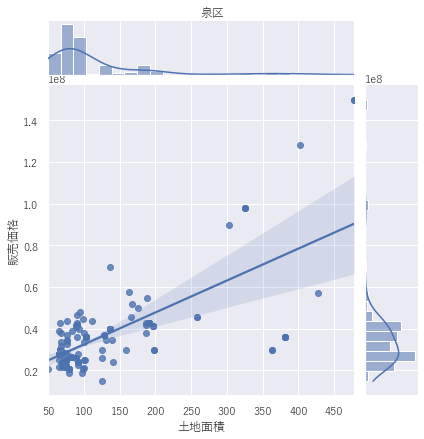

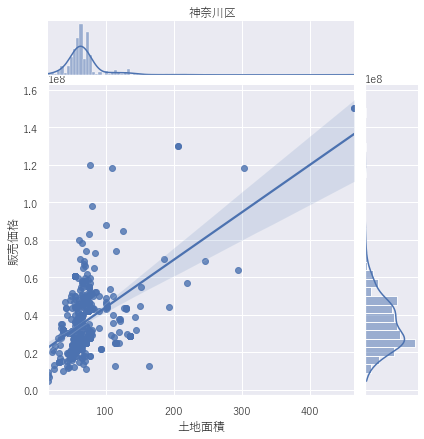

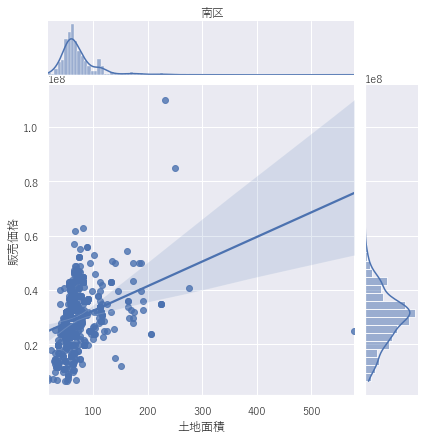

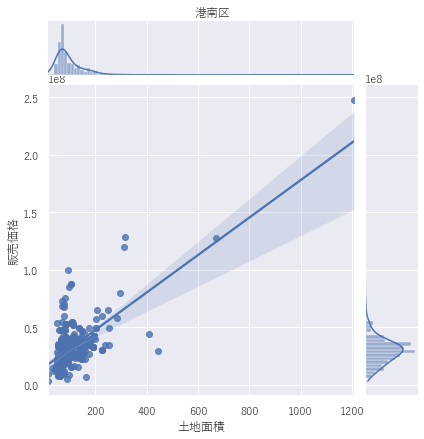

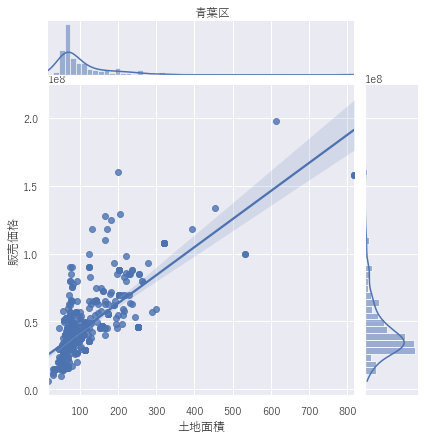

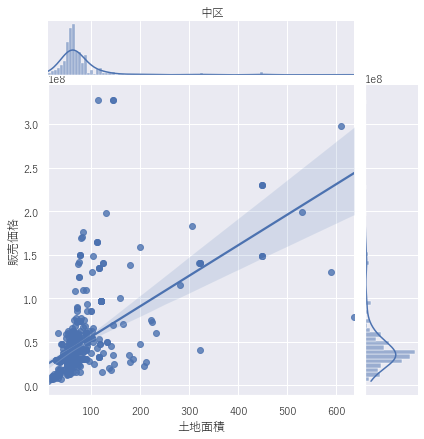

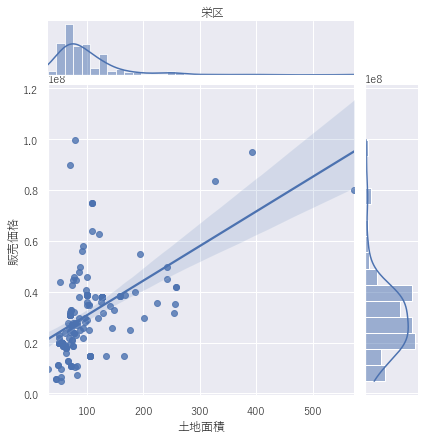

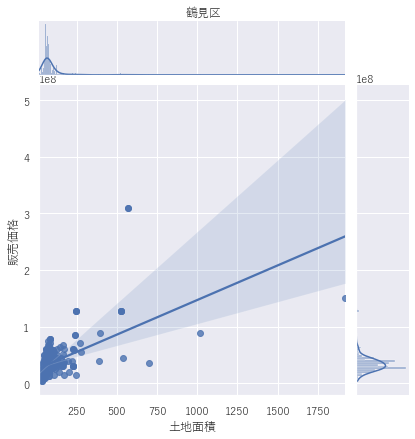

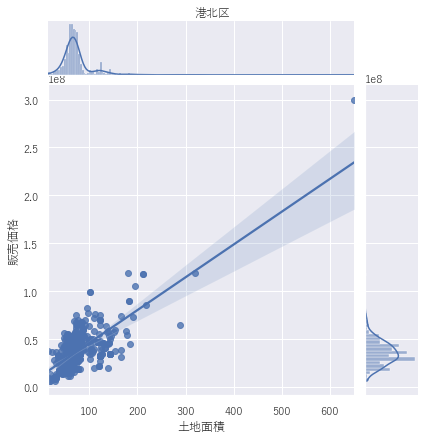

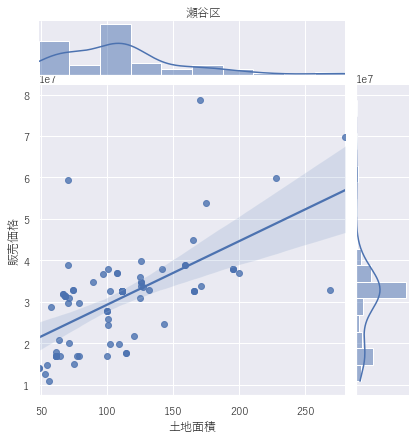

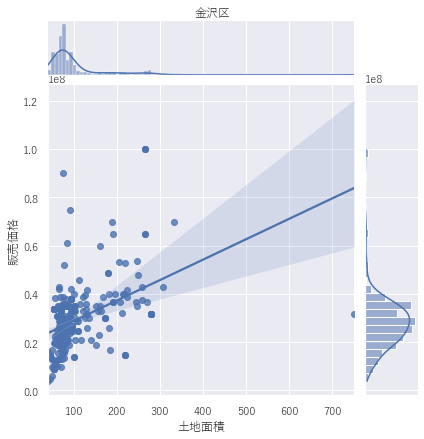

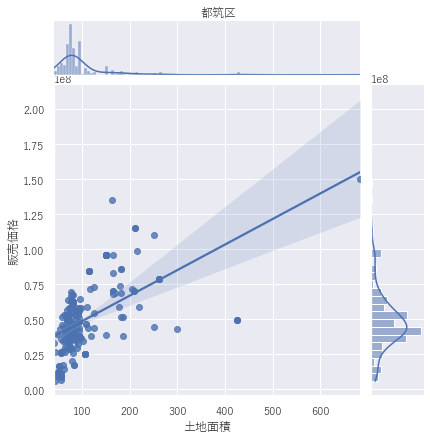

In [22]:
#区ごとに土地面積と販売価格の相関図を描く
for basho in ku:
    x = df[df["区"] == basho]["土地面積"]
    y = df[df["区"] == basho]["販売価格"]
    sns.jointplot(x=x, y=y, kind='reg') #regplotのreg
    plt.suptitle(basho, y=1.01)
    plt.show()

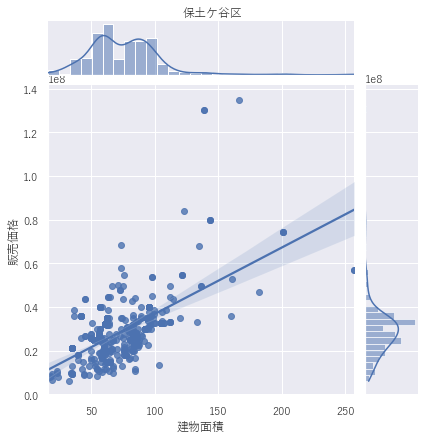

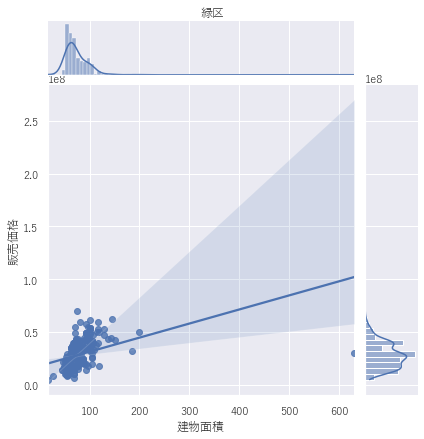

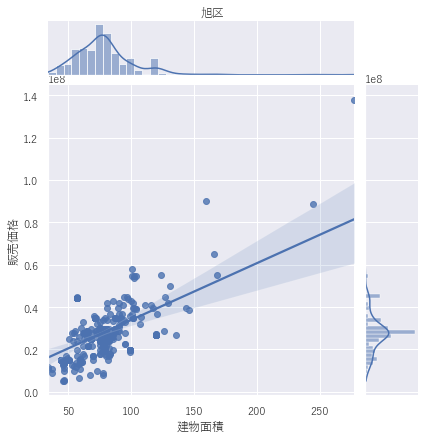

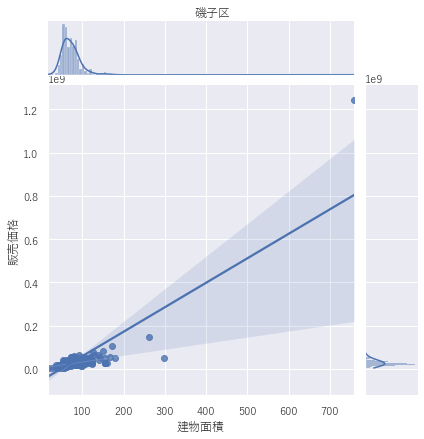

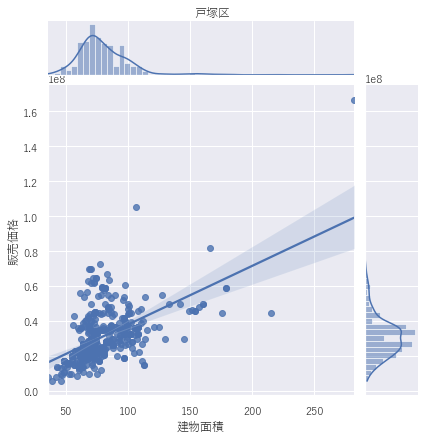

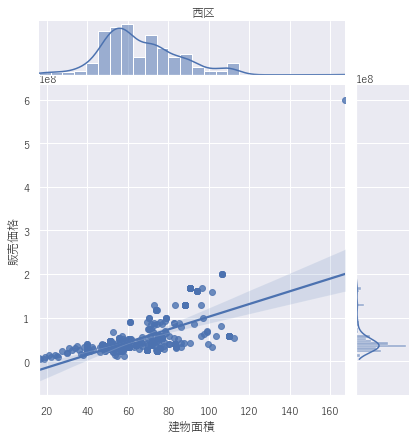

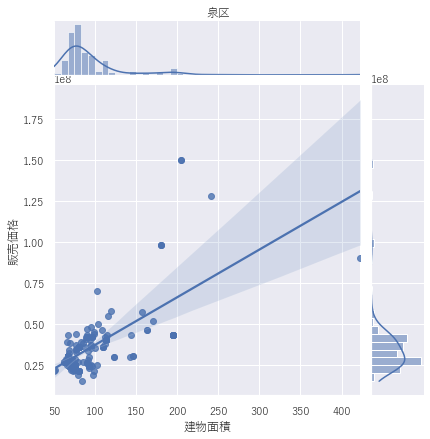

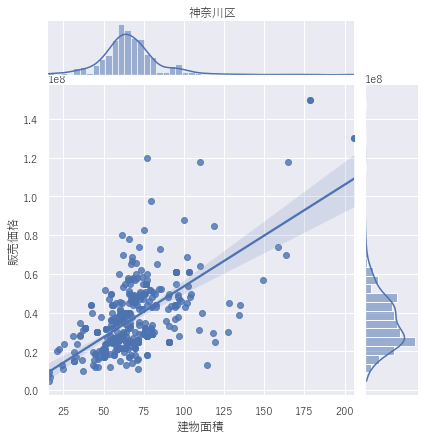

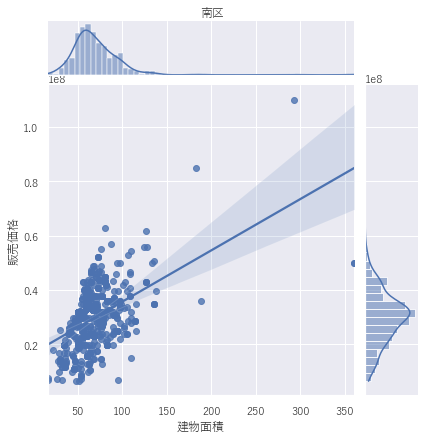

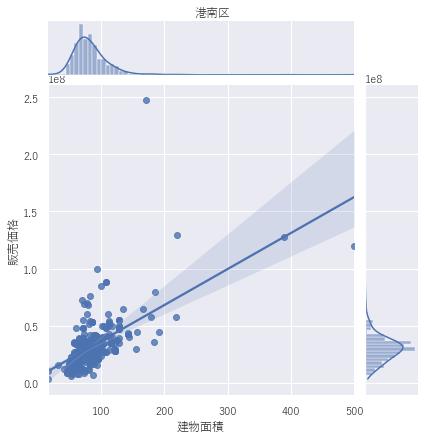

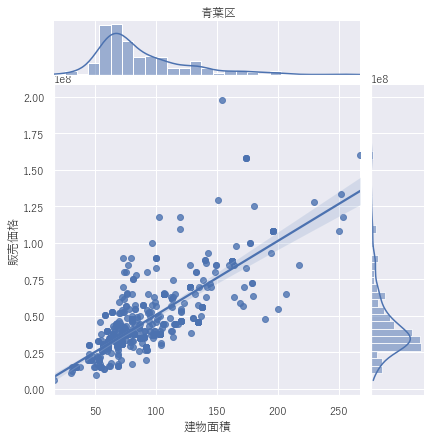

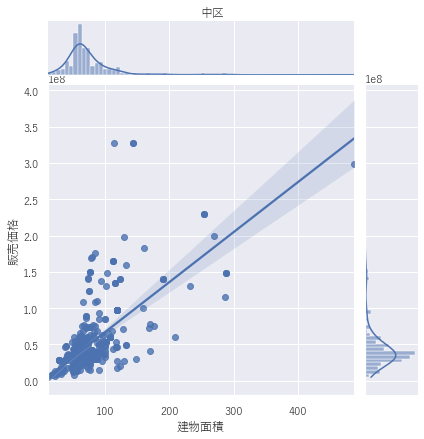

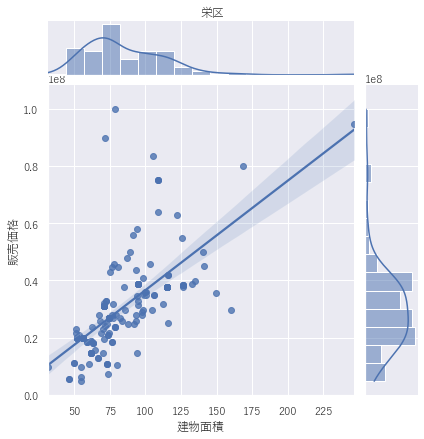

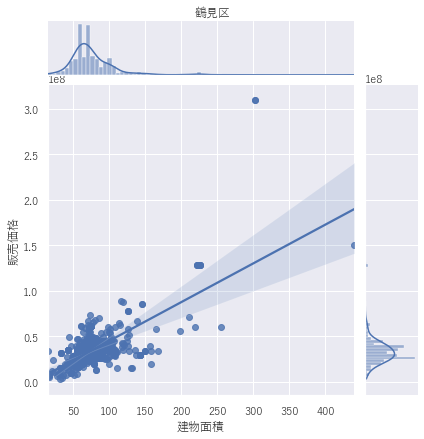

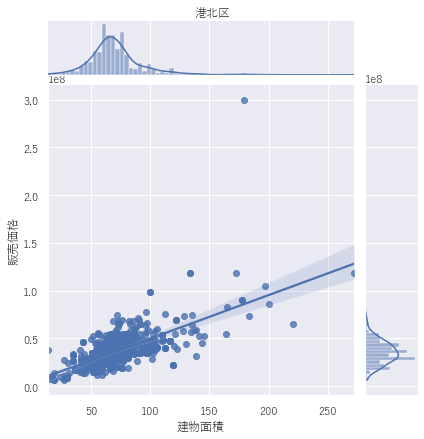

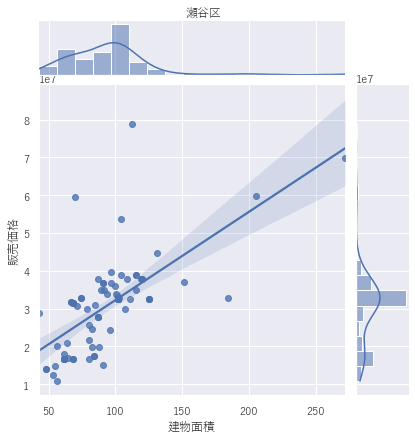

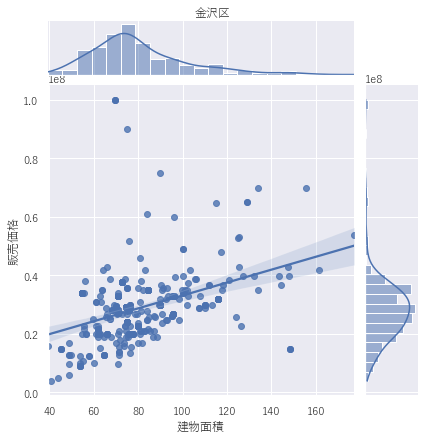

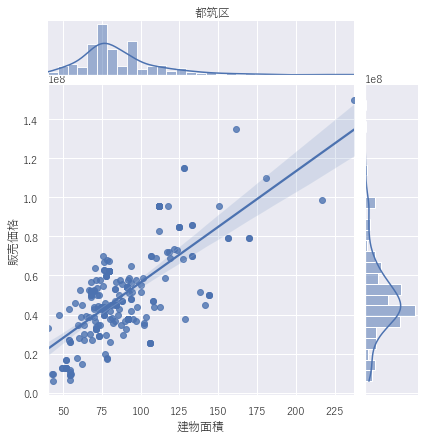

In [23]:
#区ごとに建物面積と販売価格の相関図を描く
for basho in ku:
    x = df[df["区"] == basho]["建物面積"]
    y = df[df["区"] == basho]["販売価格"]
    sns.jointplot(x=x, y=y, kind='reg')#regplotのreg
    plt.suptitle(basho, y=1.01)
    plt.show()

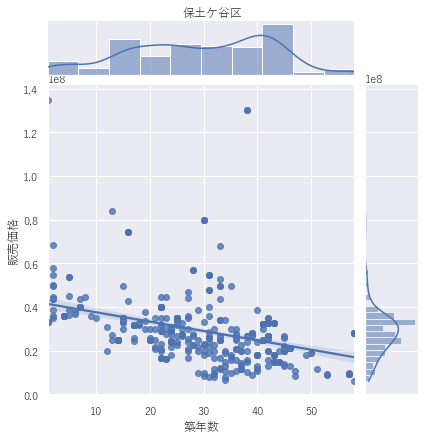

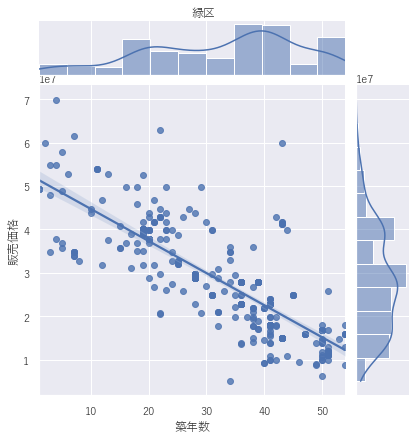

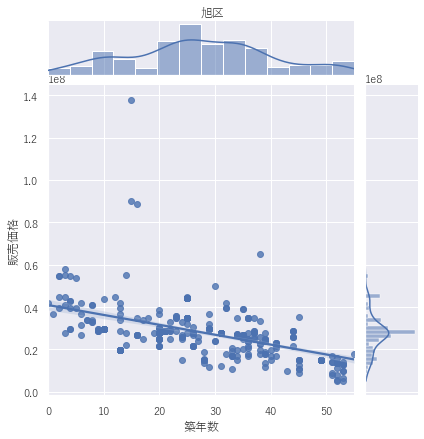

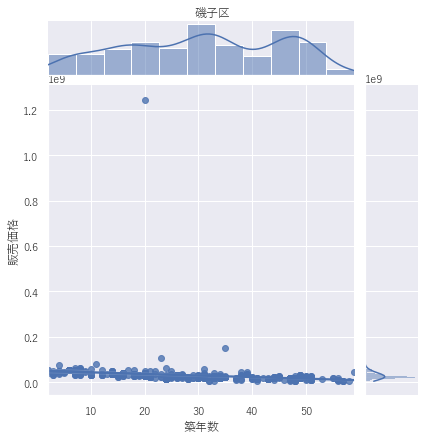

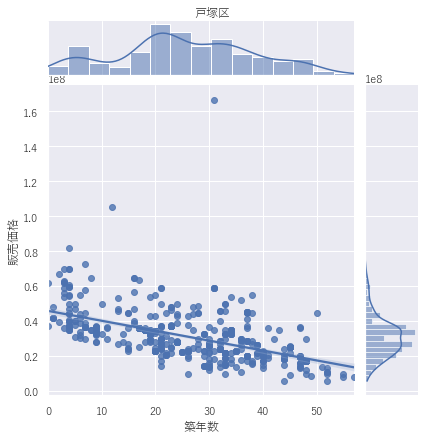

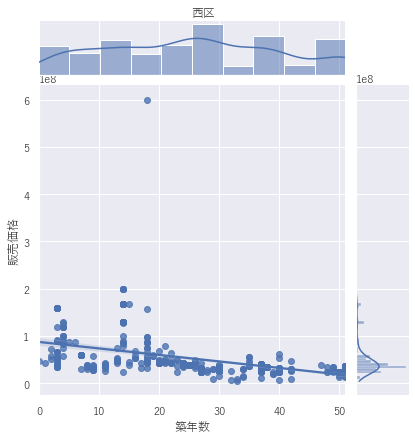

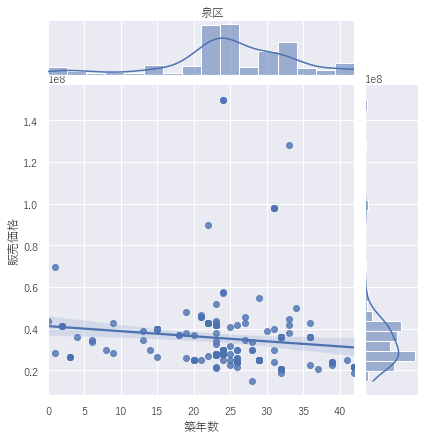

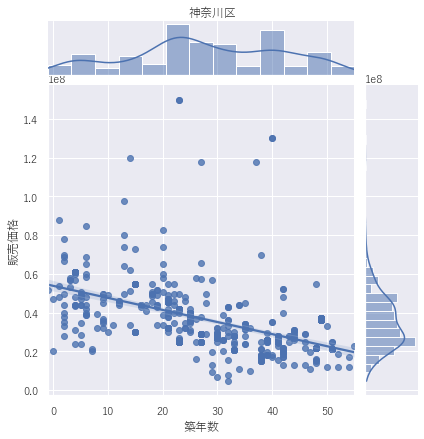

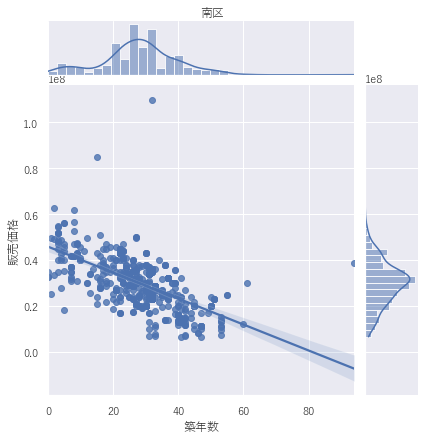

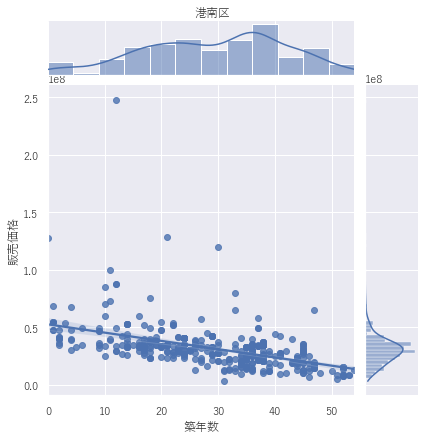

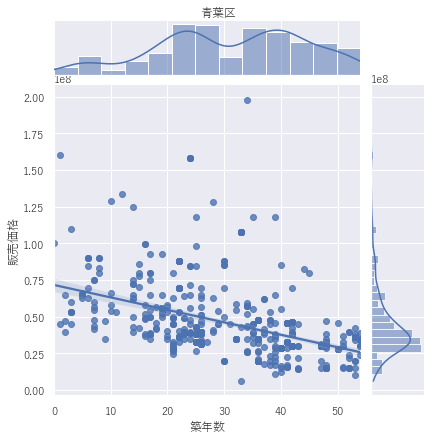

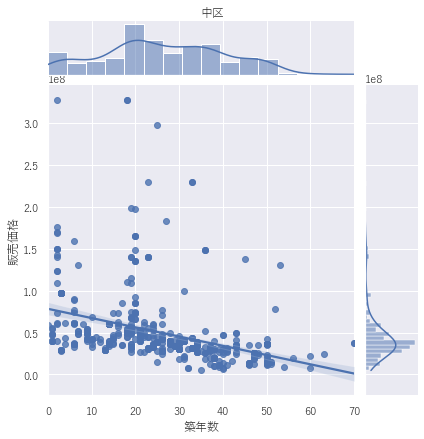

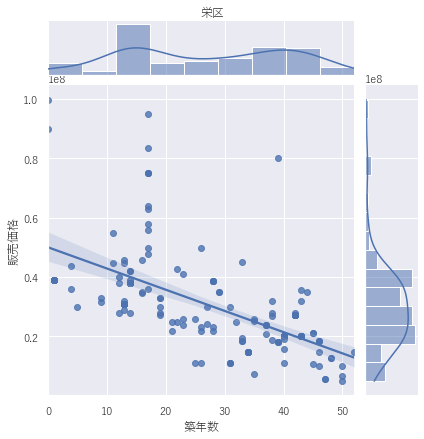

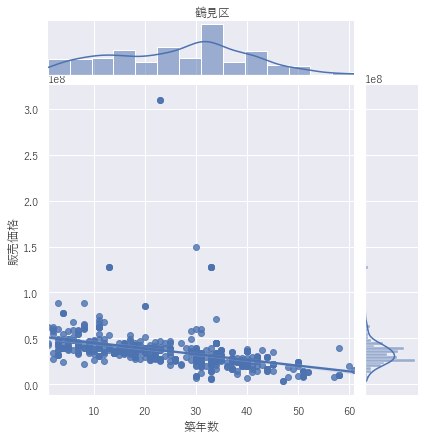

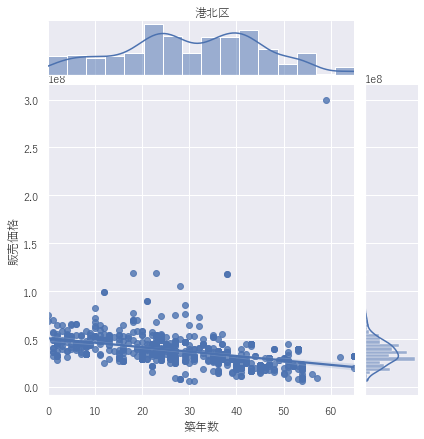

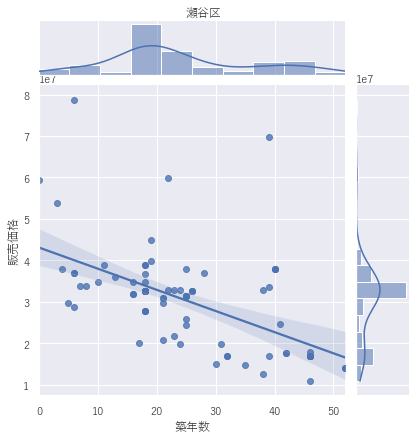

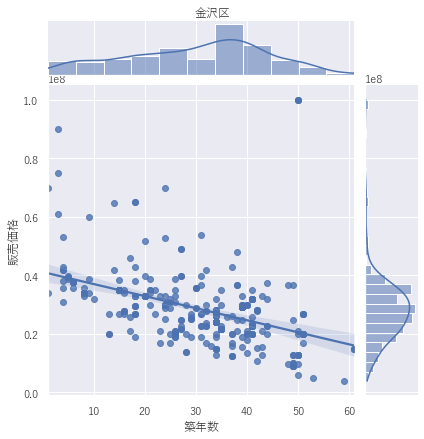

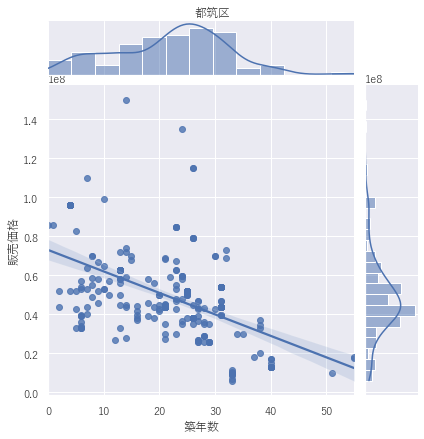

In [24]:
#区ごとに築年数と販売価格の相関図を描く
for basho in ku:
    x = df[df["区"] == basho]["築年数"]
    y = df[df["区"] == basho]["販売価格"]
    sns.jointplot(x=x, y=y, kind='reg')#regplotのreg
    plt.suptitle(basho, y=1.01)
    plt.show()

**結論**  
区ごとに見ても、概ね販売価格と土地面積・建物面積には正の相関があり、販売価格と築年数には負の相関がある  
seabornのグラフの細かい指定について→https://qiita.com/skotaro/items/7fee4dd35c6d42e0ebae

### swarmplot
物件数トップ3の港北区、鶴見区、磯子区について見てみる

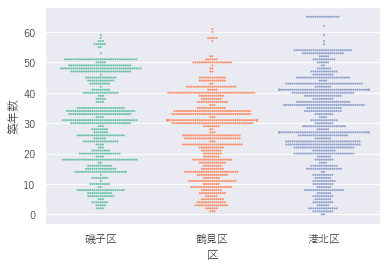

In [26]:
#築年数
area = ["港北区", "鶴見区", "磯子区"]
filt=df[df["区"].isin(area)]
sns.swarmplot(x = filt["区"], y = filt["築年数"], palette="Set2",size=2)
plt.show()
#c:\users\karin\appdata\local\programs\python\python39\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 92.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
#warnings.warn(msg, UserWarning)
#というアラームが出てたんだけど、これは点のサイズを「size=」で設定して小さくすることで解決
#グラフの大きさを変えることでも解決できそう

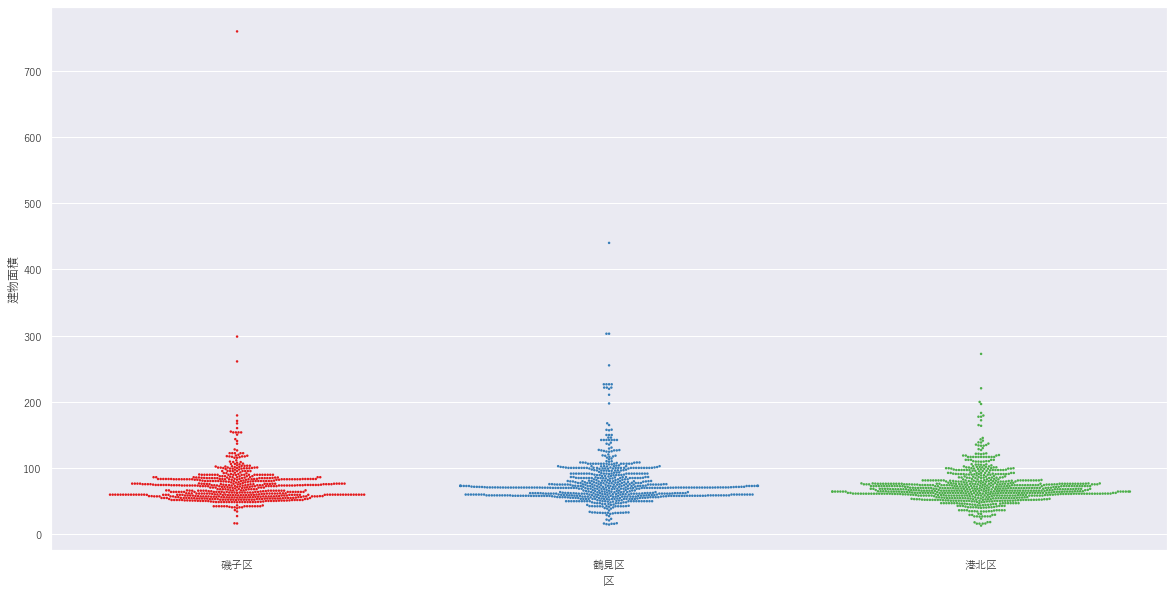

In [42]:
#建物面積
plt.rcParams["figure.figsize"] = (20, 10)
sns.swarmplot(x = filt["区"], y = filt["建物面積"], palette="Set1", size=2.5)
plt.show()

物件数トップ3に共通するのは、建物面積が100㎡以下が多い